# CoVID-19 Meta-analysis

Written by: Taylr Cawte

## Introduction 

The below report attempts to use a variety of machine learning techniques covered in MIE1624 to analyse a publicly available data-set of academic journals regarding the recent CoVID-19 outbreak. The data-set is a resource of over 45,000 scholarly articles about CoVID-19, SARS CoV-2, and other related cornaviruses. The data is freely available and is provided to the global research community to apply natural language processing and other AI techniques to generate new insights which will aid in the ongoing fight agains the novel coronavirus. The primary techniques used in this analysis were natural language processing (NLP), and several types of unsupervised learning algorithms. 

The data first underwent an initial cleaning to remove noise and prepare the raw text for analysis. A short exploratory analysis is provided to highlight the importance of academic investigations. 

Next the corpus was subjected to k-means clustering in an attempt to group abstracts with similar content. Subsequently, the themes of these clusters were identified using hierarchical clustering. Finally, the clusters with themes that were related to the current outbreak were analyzed again using hierarchical clustering in an attempt to find concepts that are related to a solution to the current outbreak. The results of this analysis are discussed in detail in the analysis section of this report. 

## Library and Data Imports 

import the standard libraries, sklearn modules, and some important nltk corpora. 

In [1]:
# standard and visualization libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from mpl_toolkits.mplot3d import Axes3D
import warnings
import numpy as np

# nltk libs
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# sklearn libs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

Mute eroneous warnings, download the stopwords library, import the data-set and check it's initial contents. <b> The stopwords corpus will need to be downloaded locally </b>

In [2]:
# ignore the haters (aka warnings)
warnings.filterwarnings('ignore')

# download stopwords corpus
# nltk.download('stopwords') # <--- uncomment me if corpus not downloaded 

# set seaborn grid style 
sns.set(style='darkgrid')

# load the data 
papers = pd.read_csv('metadata.csv', usecols=['title', 'abstract', 'authors', 'doi', 'publish_time'])

papers.head()

,title,doi,abstract,publish_time,authors
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen


In [5]:
papers.shape

(45774, 5)

## Data Cleaning 

The text data needs to be transformed into an input format that can be interpreted by the models. In order to do this unnecessary/troublesome data must be removed from the text. Duplicates within the data-set are first dropped. Next the text is cleaned; the text is converted to lower case, some punction is removed (along with unwanted words), the words are stemmed and stopwords are removed. The primary feature data in this investigation is the abstract text. 

In [3]:
papers.drop_duplicates(subset='abstract', keep='first', inplace=True)
papers.dropna(inplace=True)

# clean text data
stop = stopwords.words('english')
stop.append(['use'])
stemmer = SnowballStemmer('english', ignore_stopwords=True)

papers['cleaned_abs'] = papers['abstract'].str.lower()
papers['cleaned_abs'] = papers['cleaned_abs'].str.replace('U\.S\.A|U\.S\.A\.|U\.S\.|U\.S', 'america')
papers['cleaned_abs'] = papers['cleaned_abs'].str.replace(':|;|,|\.', '')
papers['cleaned_abs'] = papers['cleaned_abs'].str.replace('abstract|background|summary', '')
papers['split_abs'] = papers['cleaned_abs'].str.split()
papers['stemmed_abs'] = papers['split_abs'].apply(lambda x: [stemmer.stem(w) for w in x])
papers['stemmed_abs'] = papers['stemmed_abs'].str.join(' ')
papers['stemmed_abs'] = papers['stemmed_abs'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# view cleaned text
papers.stemmed_abs.head()

0    next-gener sequenc increas use studi sampl com...
1    emerg diseas one infecti epidem caus newli tra...
2    germlin variat immunoglobulin gene (ig) loci c...
3    deep sequenc clinic sampl establish tool detec...
4    develop method reconstruct transmiss histori v...
Name: stemmed_abs, dtype: object

## Exploratory Analysis


A short exploratory analysis is provided below. First; within the corpus the number of mentions of a disease should be established, this will provide insight into the portion of articles which reference each of these diseases. To do this words surrounded by brackets were analyzed; often diseases will be abbreviated (especially within the abstract), this allows the use of parantheses as identifiers for words describing a disease. Using the below helper functions words within parentheses are extracted and counted, these words are then checked. Words that do not represent diseases were removed.

In [4]:
def find_parenths(cell):
    words = re.findall('\((.*?)\)', cell)
    return words


papers['brackets'] = papers['cleaned_abs'].apply(find_parenths)
brackCount = papers['brackets'].explode().value_counts()
brackCount.head(20)

+           2079
2           1492
sars        1336
s           1126
sars-cov     980
1            921
mers-cov     883
h1n1         725
3            712
rsv          547
ibv          517
pedv         514
covid-19     492
−/−          448
n            433
pro          425
4            414
ifn          412
i            411
mhv          410
Name: brackets, dtype: int64

It can be seen that there are several non-disease realted words within parentheses throughout the corpus (as expected). The context of these words should be checked; if indeed they are not used to describe the name of a disease they are removed. 

In [5]:
pos = papers['cleaned_abs'].str.find('(+)')
pos = pos[pos != -1]
one = papers['cleaned_abs'].str.find('(1)')
one = one[one != -1]
two = papers['cleaned_abs'].str.find('(2)')
two = two[two != -1]
three = papers['cleaned_abs'].str.find('(3)')
three = three[three != -1]
four = papers['cleaned_abs'].str.find('(4)')
four = four[four != -1]
ess = papers['cleaned_abs'].str.find('(s)')
ess = ess[ess != -1]
enn = papers['cleaned_abs'].str.find('(n)')
enn = enn[enn != -1]

print('-'*20+'pos'+'-'*20)
print(papers['cleaned_abs'][list(pos.index[0:3])].head())
print('-'*20+'one'+'-'*20)
print(papers['cleaned_abs'][list(one.index[0:3])].head())
print('-'*20+'two'+'-'*20)
print(papers['cleaned_abs'][list(two.index[0:3])].head())
print('-'*20+'three'+'-'*20)
print(papers['cleaned_abs'][list(three.index[0:3])].head())
print('-'*20+'four'+'-'*20)
print(papers['cleaned_abs'][list(four.index[0:3])].head())
print('-'*20+'s'+'-'*20)
print(papers['cleaned_abs'][list(ess.index[0:3])].head())
print('-'*20+'n'+'-'*20)
print(papers['cleaned_abs'][list(enn.index[0:3])].head())

--------------------pos--------------------
1021    viruses with rna genomes dominate the eukaryot...
1128    members of the nidovirales order have (+)rna g...
1215    in recent decades many new flavi-like viruses ...
Name: cleaned_abs, dtype: object
--------------------one--------------------
337    the rapid spread of coronavirus disease 2019 (...
354    the current state of much of the wuhan pneumon...
447    objective to analyze the clinical characterist...
Name: cleaned_abs, dtype: object
--------------------two--------------------
337    the rapid spread of coronavirus disease 2019 (...
354    the current state of much of the wuhan pneumon...
447    objective to analyze the clinical characterist...
Name: cleaned_abs, dtype: object
--------------------three--------------------
337    the rapid spread of coronavirus disease 2019 (...
345     in response to the covid-19 outbreak we aimed...
447    objective to analyze the clinical characterist...
Name: cleaned_abs, dtype: object
---

After reviewing the above selection it can be seen that +, 1, 2, 3, 4, 5, and n do not correspond to a disease and can therefore be removed from the list. Finally the number of occurences of mentions of a disease can be plotted. It can be seen that the most mentioned diseases in this corpus are SARS-COV, MERS-COV, H1N1 (swine flu), and RSV (human orthopneumovirus). It can also be seen that within this corpus the 7th most referenced disease is CoVID-19. 

Text(0.5, 1.0, 'Most commonly referenced diseases')

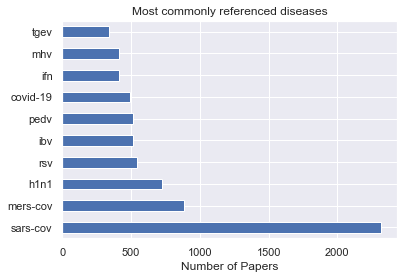

In [6]:
# drop bracketed items that don't reference disease
brackCount.drop(['+', '2', 's', '1', '3', 'pro', 'n', '4', 'i', 'ii', '50'], inplace=True)
brackCount.drop(brackCount.index[8], inplace=True)
brackCount['sars-cov'] += brackCount['sars']
brackCount.drop('sars', inplace=True)

# plot the number of occurences of disease related words in parentheses 
brackCount[:10].plot(kind='barh')
plt.xlabel('Number of Papers')
plt.title('Most commonly referenced diseases')

Next it would be interesting to view the distribution of papers with respsect to the year they were published. This will provided insight into the level of investigation being conducted into coronaviruses/coronavirus related diseases. Some important disease outbreaks are highlighted below, they include the 2003 SARS outbreak, the 2012 MERS outbreak, and the 2018 MERS outbreak. MERS and SARS were novel coronavriuses at the time, and prior to the 2003 and 2012 outbreaks they did not exist in humans as they were transmitted from animals to human. 

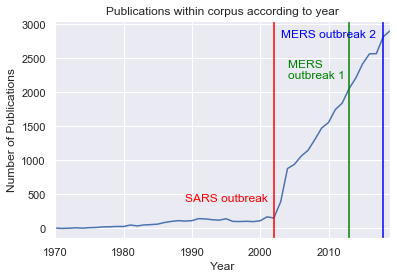

In [36]:
# parse date published and plot number of publications as a function of year
papers['date'] = papers['publish_time'].str.split('-')
papers['Year'] = papers['date'].str[0]
papers['month'] = papers['date'].str[1]
papers['day'] = papers['date'].str[2]

pubCount = papers.groupby(['Year']).size().to_frame('count').reset_index()
pubCount.set_index('Year', drop=True, inplace=True)
ax = pubCount.drop('2020').plot(kind='line', legend=False)
ax.axvline(32, color='red')
ax.axvline(43, color='green')
ax.axvline(48, color='blue')
plt.text(19, 400, 'SARS outbreak', color='red')
plt.text(34, 2200, 'MERS \noutbreak 1', color='green')
plt.text(33, 2800, 'MERS outbreak 2', color='blue')
plt.ylabel('Number of Publications')
plt.title('Publications within corpus according to year')
plt.show()

It would be interesting to see how the literature behaves with respect to these pandemics, the number of papers published with mention of each disease is shown below. It can be seen that prior to 2003 no mention of SARS can be found in the literature; this is because the disease did not exist before 2003. In the year after it's discovery the number of papers published regarding SARS increases sharply before tapering off in successive years. A similar behaviour is noted in the MERS outbreaks, it was first discovered in 2012, experiences a sharp increase in publications, the begins to taper off. With respect to the MERS outbreak however the pullback in paper publication is not as drastic due to the second MERS outbreak in 2018.  

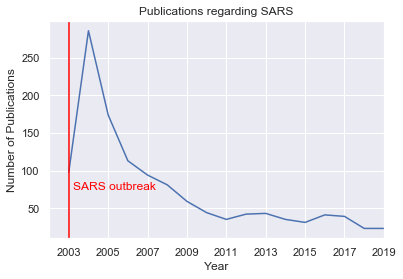

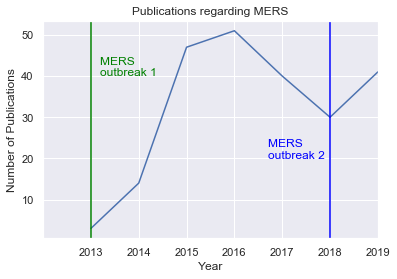

In [8]:
# plot number of papers regarding specific coronaviruses
# human coronaviruses 229E, NL63, OC43, and HKU1 are common, MERS and SARS were transmitted in the early 2000s and are
# more severe


def disease_type(cell):
    if ('(sars)' or '(sars-cov)' or '(sarscov)') in cell:
        type = 'sars'
    elif ('(mers)' or '(mers-cov)' or '(merscov)') in cell:
        type = 'mers'
    else:
        type = 'other'
    return type


papers['disease type'] = papers['cleaned_abs'].apply(disease_type)

sarsPapers = papers[papers['disease type'] == 'sars']
sarsCount = sarsPapers.groupby(['Year']).size().to_frame('count').reset_index()
sarsCount.set_index('Year', drop=True, inplace=True)
ax2 = sarsCount.drop('2020').plot(kind='line', legend=False)
ax2.axvline(0, color='red')
plt.text(0.2, 74, 'SARS outbreak', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xlim(left=-1)
plt.title('Publications regarding SARS')
plt.show()

mersPapers = papers[papers['disease type'] == 'mers']
mersCount = mersPapers.groupby(['Year']).size().to_frame('count').reset_index()
mersCount.set_index('Year', drop=True, inplace=True)
ax1 = mersCount.drop('2020').plot(kind='line', legend=False)
ax1.axvline(0, color='green')
ax1.axvline(5, color='blue')
plt.text(0.18, 40, 'MERS \noutbreak 1', color='green')
plt.text(3.7, 20, 'MERS \noutbreak 2', color='blue')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xlim(left=-1)
plt.title('Publications regarding MERS')
plt.show()

It is interesting to note that after each of these disease outbreaks there is a period of increased research and then a pull back as interest in the diseases decline. Ideally the level of publications would rise at a constant rate to show continuing investigation into the diseases and not investigation that are some sort of 'fad'.

As we are interested in finding resolutions to the outbreak another usful investigation would be to find the topics most often covered within this corpus. It can be seen that the majority of solutions discussed focus on treatments/vacciniations or clinical remedies to disease outbreaks, dealing with viruses on a public health level seems to be discussed less often.  

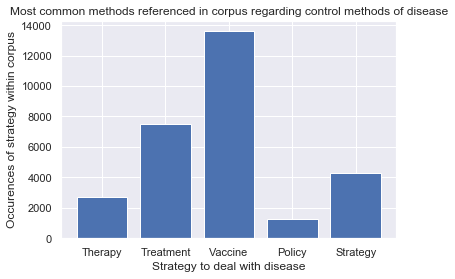

In [35]:
therapy = papers['stemmed_abs'].str.count(' therapi ').sum()
treatment = papers['stemmed_abs'].str.count(' treatment ').sum()
vaccine = papers['stemmed_abs'].str.count(' vaccin ').sum()
policy = papers['stemmed_abs'].str.count(' polici ').sum()
strategy = papers['stemmed_abs'].str.count(' strategi ').sum()

height = [therapy, treatment, vaccine, policy, strategy]
bars = ('Therapy', 'Treatment', 'Vaccine', 'Policy', 'Strategy')
ypos = np.arange(len(bars))

plt.figure()
plt.bar(ypos, height)
plt.xticks(ypos, bars)
plt.xlabel('Strategy to deal with disease')
plt.ylabel('Occurences of strategy within corpus')
plt.title('Most common methods referenced in corpus regarding control methods of disease')
plt.show()

## Model Preparation and Analysis

The text within the cleaned abstracts was vectorized using TFIDF and used as the features for this investigation. 

The strategy used to analyse the data is as follows. Kmeans clustering was conducted in an effort to group similar papers together, the elbow method was used to determine the ideal number of clusters. The clustered data sets were then analyzed using hierarchical clustering to identify a theme for each cluster. Once cluster themes were established a deeper investigation into certain clusters was conducted in an effort to establish potential areas of interest or policy related ideas that could aid in the containment/control of the novel coronavirus outbreak. 

### Clustering Similar Papers and Theme Identification

In [9]:
# features
vectorizer = TfidfVectorizer(max_features=2**12)
x = vectorizer.fit_transform(papers['stemmed_abs'].values)

k = 1
k = 6
k = 11
k = 16
k = 21
k = 26
k = 31
k = 36
k = 41
k = 46


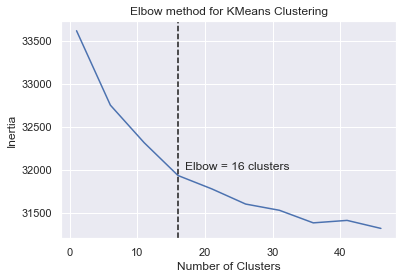

In [33]:
# kmeans
ss_distance = []
k_range = range(1, 50, 5)

for k in k_range:
    print('k = {}'.format(k))
    mbk = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=101)
    mbk = mbk.fit(x.toarray())
    ss_distance.append(mbk.inertia_)

plt.figure()
plt.plot(k_range, ss_distance)
plt.axvline(16, color='k', ls='--')
plt.text(17, 32000, 'Elbow = 16 clusters')
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')
plt.title('Elbow method for KMeans Clustering')
plt.show()

Now that the ideal number of clusters is known the K-means clustering will be conducted using 16 clusters. The results of the clustering will undergo dimensionality reduction using PCA. The clusters are visualized in 2 and 3 dimensions. 

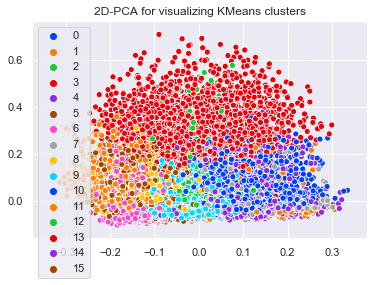

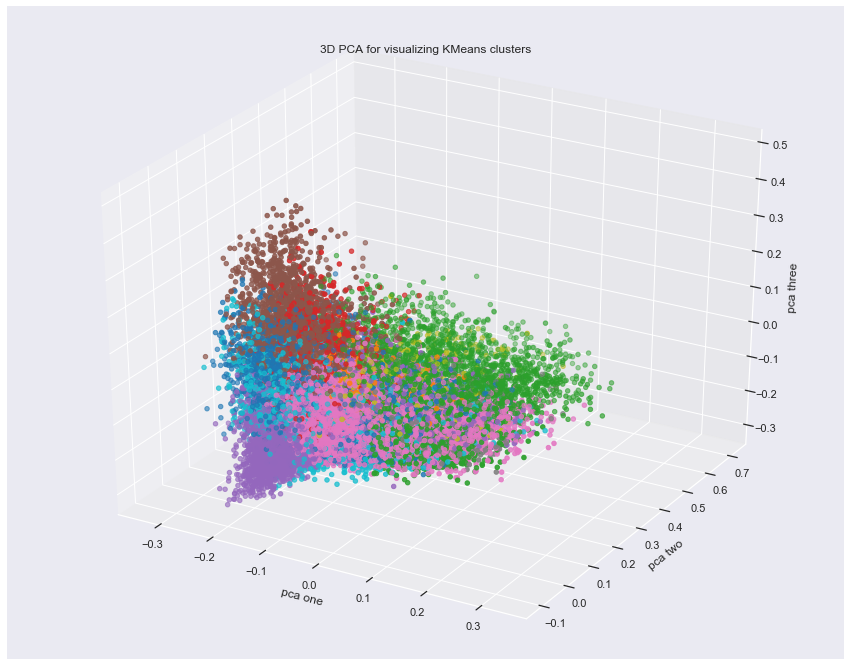

In [34]:
# ----------------------------- compute with ideal number of clusters and plot with PCA/tSNE------------------------------- #
k = 16  # ideal number of clusters was 13
mbk = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=101)
pred = mbk.fit_predict(x)

papers['cluster'] = mbk.labels_

palette = sns.color_palette('bright', len(set(pred)))

pca = PCA(n_components=3)
pcaRes = pca.fit_transform(x.toarray())

plt.figure() # 2D plot
sns.scatterplot(pcaRes[:, 0], pcaRes[:, 1], hue=pred, legend='full', palette=palette)
plt.title('2D-PCA for visualizing KMeans clusters')
plt.show()

ax = plt.figure(figsize=(15,12)).gca(projection='3d') # 3D plot
ax.scatter(
    xs=pcaRes[:, 0],
    ys=pcaRes[:, 1],
    zs=pcaRes[:, 2],
    c=pred,
    cmap='tab10'
)

ax.set_xlabel('pca one')
ax.set_ylabel('pca two')
ax.set_zlabel('pca three')
plt.title('3D PCA for visualizing KMeans clusters')
plt.show()


Now using TFIDF and hierarchical clustering using cosine similarity and wards method the most common words within each cluster will be identified. This will highlight themes for each of the clusters, the cluster themes are summarized in the table below.

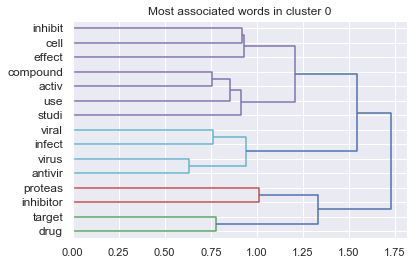

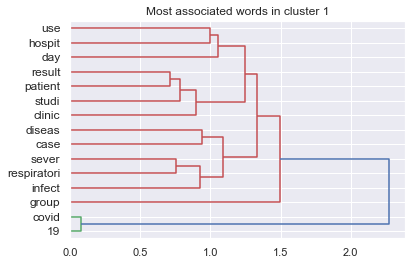

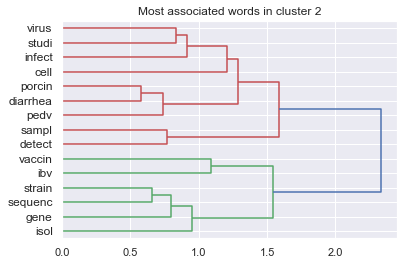

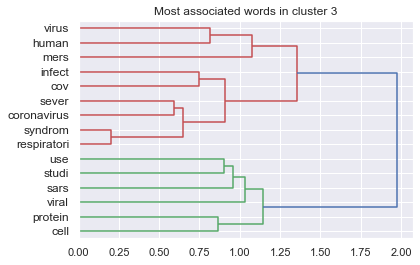

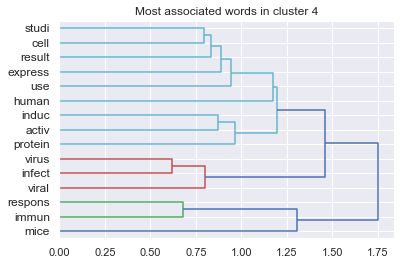

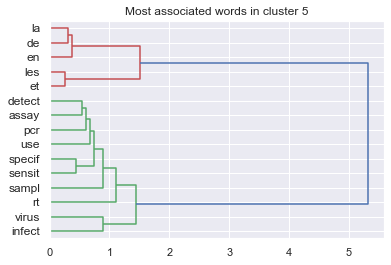

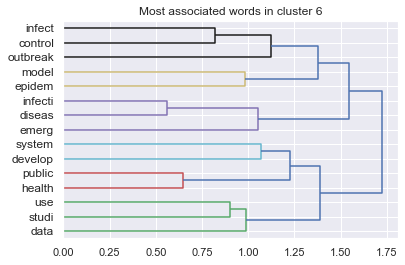

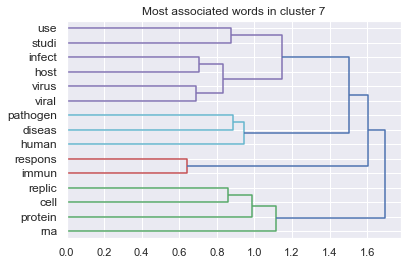

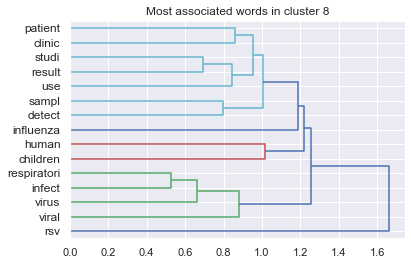

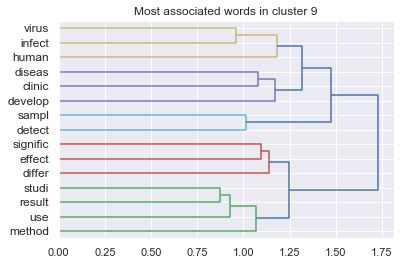

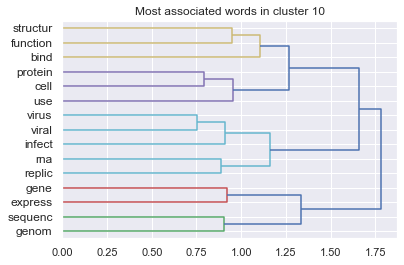

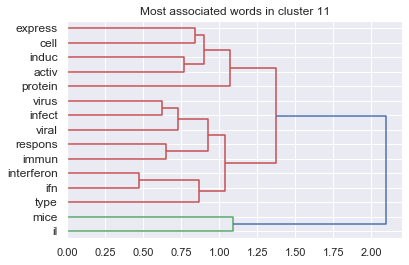

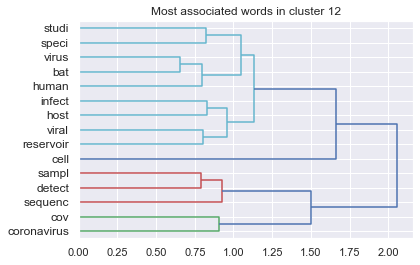

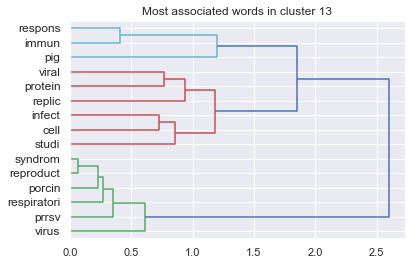

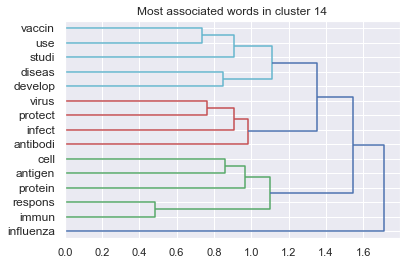

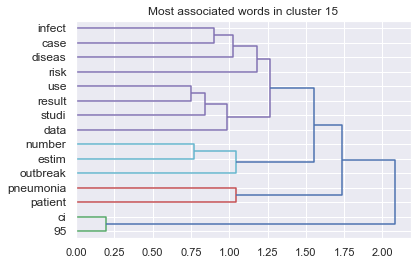

In [12]:
clusters = {}

for i in range(k):
    clusters[i] = papers[papers.cluster == i]

vectorizer = TfidfVectorizer(max_features=15) # use top 15 words to identify themes 

for dct in clusters:
    features = pd.DataFrame(vectorizer.fit_transform(clusters[dct]['stemmed_abs']).toarray(),
                            columns=vectorizer.get_feature_names()).T
    dist = 1-cosine_similarity(features)

    linkage = ward(dist)

    fig, ax = plt.subplots()
    ax = dendrogram(linkage, labels=vectorizer.get_feature_names(), orientation='right')
    plt.title('Most associated words in cluster {}'.format(dct))

<table>
    <tr>
        <th> Cluster </th>
        <th> Theme </th>
    </tr>
    <tr>
        <td> Cluster 0 </td>
        <td> General viral inhibition using different drug treatments </td>
    </tr>
    <tr>
        <td> Cluster 1 </td>
        <td> Serious/severe CoVID-19 disease and at-risk groups </td>
    </tr>
    <tr>
        <td> Cluster 2 </td>
        <td> Avian/porcine coronavirus treatment/detection </td>
    </tr>
    <tr>
        <td> Cluster 3 </td>
        <td> MERS/SARS coronavriuses, specifically regarding human infection </td>
    </tr>
    <tr>
        <td> Cluster 4 </td>
        <td> Human immune responses to viral activity and correlation to mice models </td>
    </tr>
    <tr>
        <td> Cluster 5 </td>
        <td> French papers and virus detection techniques </td>
    </tr>
    <tr>
        <td> Cluster 6 </td>
        <td> Infectious disease outbreak control measures in a public health capacity </td>
    </tr>
    <tr>
        <td> Cluster 7 </td>
        <td> Human immune response to viral infections, cellular investigations </td>
    </tr>
    <tr>
        <td> Cluster 8 </td>
        <td> Human clinical studies on children infected with the flu </td>
    </tr>
    <tr>
        <td> Cluster 9 </td>
        <td> Virus detection methods in clinical studies </td>
    </tr>
    <tr>
        <td> Cluster 10 </td>
        <td> Viral genetic sequencing techniques, structure and function of viruses at cellular level  </td>
    </tr>
    <tr>
        <td> Cluster 11 </td>
        <td> Viral activity in mice models </td>
    </tr>
    <tr>
        <td> Cluster 12 </td>
        <td> Coronavirus detection and genetic sequencing from bat reservoirs </td>
    </tr>
    <tr>
        <td> Cluster 13 </td>
        <td> Porcine immune response to viral respiratory infections </td>
    </tr>
    <tr>
        <td> Cluster 14 </td>
        <td> Vaccine development and immune system response to influenza  </td>
    </tr>
    <tr>
        <td> Cluster 15 </td>
        <td> Risk factors for infections in respiratory disease outbreaks </td>
    </tr>

Now that themes of clusters have been identified can be conducted to potentially aid in policy development or provide insights for use by clinicians. Clusters 6, 1, and 15 were further investigated. These clusters have papers which contain investigations on infectious disease outbreaks in a public health capacity, severe CoVID-19 infections, and risk factors for contracting respiratory disease. These clusters were chosen for further analaysis as they seemed most pertinent to developing insights about the current outbreak, however, there are a plethora of investigations which could be conducted on this data and the author of this investigation encourages readers to carry out their own furhter investigations.

### Cluster 6 Analysis

Cluster 6 contains papers discussing infectious disease outbreaks which are tackled from a public health/epidimeological standpoint. The goal of this analysis was to determine strategies which could be implemented by governments/lawmakers to contain the spread of CoVID-19.  

The approach used was to compute the distance between certain 'positive' or target words and the words within the selection of text. The target words in this case were detect, prevent, spread, reduce, strategy, success, and decrease; all of which are related to decreasing the advancement of the disease. 

In [13]:
vectorizer = TfidfVectorizer(max_features=800)
#
features = pd.DataFrame(vectorizer.fit_transform(clusters[6]['stemmed_abs']).toarray(),
                        columns=vectorizer.get_feature_names()).T

dist = 1-cosine_similarity(features)
featureWords = vectorizer.get_feature_names()

detInd = np.arange(len(dist[featureWords.index('detect')]))
prevInd = np.arange(len(dist[featureWords.index('prevent')]))
spreadInd = np.arange(len(dist[featureWords.index('spread')]))
redInd = np.arange(len(dist[featureWords.index('reduc')]))
stratInd = np.arange(len(dist[featureWords.index('strategi')]))
succInd = np.arange(len(dist[featureWords.index('success')]))
decInd = np.arange(len(dist[featureWords.index('decreas')]))


def cluster_words(index, features, target):
    target_words = sorted(zip(dist[features.index(target)], index))
    out_words = []
    for word in target_words[0:60]:
        out_words.append(features[word[1]])

    return out_words


detWords = cluster_words(detInd, featureWords, 'detect')
prevWords = cluster_words(prevInd, featureWords, 'prevent')
spreadWords = cluster_words(spreadInd, featureWords, 'spread')
redWords = cluster_words(redInd, featureWords, 'reduc')
stratWords = cluster_words(stratInd, featureWords, 'strategi')
succWords = cluster_words(succInd, featureWords, 'success')
decWords = cluster_words(decInd, featureWords, 'decreas')

df = pd.DataFrame([detWords, prevWords, spreadWords, redWords, stratWords, succWords, decWords], 
                    index=['detect', 'prevent', 'spread', 'reduce', 'strategy', 'success', 'decrease']).T

df.head(15)

,detect,prevent,spread,reduce,strategy,success,decrease
0,detect,prevent,spread,reduc,strategi,success,decreas
1,surveil,control,diseas,effect,effect,health,increas
2,earli,diseas,epidem,diseas,control,control,year
3,system,infect,infect,strategi,optim,strategi,rate
4,outbreak,health,model,result,diseas,well,effect
5,diseas,measur,network,intervent,intervent,major,result
6,sensit,infecti,dynam,infect,use,use,death
7,method,public,popul,mortal,implement,public,age
8,syndrom,practic,infecti,cost,result,implement,diseas
9,health,includ,simul,health,reduc,communiti,trend


By analyzing the word associations in the above dataframe it can be seen that in general an effetive strategy for reducing the spread of infectious diseases to prevent public health emergencies involves a multifaceted approach. Firstly, for adequate detection some words that should be highlighted include; 'surveilance', 'early', 'data', 'public', 'time', and 'event'. A policy insight that could be derived from this is that adequate detection requires public surveilance and data collection on emergent diseases. Early detection using these strategies could give lawmakers and heatlhcare systems extra time. In fact, each of the columns presented above hinge similarly on early detection through some sort of data collection and using this information to control population movements to limit spread of the disease. This implies that an effective strategy to deal with emergent diseases is through monitoring and investigation, then implementing a general containment strategy that involves some sort of population/public control. This is very similar to the quarantine strategies being implemented by many nations currently facing the CoVID 19 epidemic.

### Cluster 1 Analysis

A similar analysis to the above is conducted on cluster 1 which has papers that are focused on severe cases of the novel coronavirus. The features in cluster 1 will be clustered around 'therapy', 'treatment', 'positive', 'cure', 'vaccine', and 'recover' to see if there are any treatment methods which may be helpful to deal with this virus. 

In [14]:
vectorizer = TfidfVectorizer(max_features=800)

features = pd.DataFrame(vectorizer.fit_transform(clusters[1]['stemmed_abs']).toarray(),
                        columns=vectorizer.get_feature_names()).T

dist = 1-cosine_similarity(features)
featureWords = vectorizer.get_feature_names()

treInd = np.arange(len(dist[featureWords.index('treatment')]))
therInd = np.arange(len(dist[featureWords.index('therapi')]))
posInd = np.arange(len(dist[featureWords.index('posit')]))
recovInd = np.arange(len(dist[featureWords.index('recov')]))
# vacInd = np.arange(len(dist[featureWords.index('vaccin')]))
# cureInd = np.arange(len(dist[featureWords.index('cure')]))


def cluster_words(index, features, target):
    target_words = sorted(zip(dist[features.index(target)], index))
    out_words = []
    for word in target_words[0:60]:
        out_words.append(features[word[1]])

    return out_words


treWords = cluster_words(detInd, featureWords, 'treatment')
therWords = cluster_words(prevInd, featureWords, 'therapi')
posWords = cluster_words(spreadInd, featureWords, 'posit')
recovWords = cluster_words(redInd, featureWords, 'recov')
# vacWords = cluster_words(redInd, featureWords, 'vaccin')
# cureWords = cluster_words(redInd, featureWords, 'cure')

df = pd.DataFrame([treWords, therWords, posWords, recovWords], 
                    index=['treatment', 'therapy', 'positive', 'recovery']).T

df.head(20)

,treatment,therapy,positive,recovery
0,treatment,therapi,posit,recov
1,patient,receiv,negat,follow
2,conclus,patient,result,patient
3,effect,use,pcr,up
4,clinic,treatment,test,long
5,treat,improv,patient,term
6,improv,antivir,sampl,h7n9
7,receiv,treat,rt,treatment
8,diagnosi,conclus,nucleic,compar
9,method,acut,method,studi


It should be noted that an attempt was made to calcualte the distances between the words 'cure' and 'vaccine' and the features in the severe coronavirus cluster however no mention of cure or vaccine was found. This is in keeping with reports in the media and medical reports that there is no cure for the novel coronavirus at present time and provides evidence that the clustering method and identification of theme is accurate. 

At first glance the associations between the words in the severe coronavirus case cluster and the target words ('treatment', 'therapy', 'positive', and 'recovery') are not as fruitful as in the infectious disease control cluster, however, there is still some interesting connections that can be made. It can be seen that in the therapy category, 'corticosteroid' appears. This may suggest an investigation into using corticosteroids for a coronavirus therapy would be helpful. Additionally, when analyzing the recovery category it can be seen that 'h7n9' (influenza type A) appears high on the list. This may suggest that there is an association between the recovery of h7n9 patients and the recovery of CoVID-19 patients. In order to aid researchers and policy markers the papers which contain mention of h7n9 within cluster 1 are presented below and should be reviewed by clinicians to attempt to determine a throughline between the recovery of h7n9 and CoVID-19 patients.

In [15]:
df = clusters[1]
homework = df[df['stemmed_abs'].str.contains('h7n9')]
length = len(homework)
homework.head(length)

,title,doi,abstract,publish_time,authors,cleaned_abs,split_abs,stemmed_abs,brackets,date,Year,month,day,disease type,cluster
6060,Clinical Features and Factors Associated with ...,10.1371/journal.pone.0073362,OBJECTIVE: The present study aimed to analyze ...,2013-09-17,"Chen, Xiaorong; Yang, Zongguo; Lu, Yunfei; Xu,...",objective the present study aimed to analyze c...,"[objective, the, present, study, aimed, to, an...",object present studi aim analyz clinic featur ...,"[p = 0023, tcm, p = 001, p = 0011 004 and 0016...","[2013, 09, 17]",2013,09,17,other,1
6118,Probable person to person transmission of nove...,10.1136/bmj.f4752,Objective To determine whether the novel avian...,2013-08-06,"Qi, Xian; Qian, Yan-Hua; Bao, Chang-Jun; Guo, ...",objective to determine whether the novel avian...,"[objective, to, determine, whether, the, novel...",object determin whether novel avian influenza ...,"[rrt-pcr, the index patient]","[2013, 08, 06]",2013,08,06,other,1
6538,Comparison of Patients Hospitalized With Influ...,10.1093/cid/ciu053,Background. Influenza A(H7N9) viruses isolated...,2014-04-15,"Wang, Chen; Yu, Hongjie; Horby, Peter W.; Cao,...",influenza a(h7n9) viruses isolated from human...,"[influenza, a(h7n9), viruses, isolated, from, ...",influenza a(h7n9) virus isol human show featur...,"[h7n9, ph1n1, n = 123, n = 119 43 china 76 vie...","[2014, 04, 15]",2014,04,15,other,1
6573,Association of Radiologic Findings with Mortal...,10.1371/journal.pone.0093885,BACKGROUND: The novel H7N9 virus causes severe...,2014-04-04,"Feng, Feng; Jiang, Yebin; Yuan, Min; Shen, Jie...",the novel h7n9 virus causes severe illness in...,"[the, novel, h7n9, virus, causes, severe, illn...",novel h7n9 virus caus sever ill includ pneumon...,"[n = 15, n = 7, 5/15, p<005, 4/15, p<005, p<00...","[2014, 04, 04]",2014,04,04,other,1
6772,Lung ultrasound imaging in avian influenza A (...,10.1186/2036-7902-6-6,BACKGROUND: Lung ultrasound has been shown to ...,2014-05-20,"Tsai, Nga Wing; Ngai, Chun Wai; Mok, Ka Leung;...",lung ultrasound has been shown to identify in...,"[lung, ultrasound, has, been, shown, to, ident...",lung ultrasound shown identifi real-tim variou...,"[ards, h7n9]","[2014, 05, 20]",2014,05,20,other,1
6786,Immune derangement occurs in patients with H7N...,10.1186/cc13788,"INTRODUCTION: Currently, little is known about...",2014-03-24,"Wu, Wei; Shi, Yu; Gao, Hainv; Liang, Weifeng; ...",introduction currently little is known about t...,"[introduction, currently, little, is, known, a...",introduct current littl known immunolog charac...,"[h7n9, hcs, 704%, 481%, 74%, sirs defined as h...","[2014, 03, 24]",2014,03,24,other,1
7372,A confirmed severe case of human infection wit...,10.3892/etm.2014.2159,"A male patient, aged 77 years, was admitted to...",2014-12-30,"CAO, HUI-FANG; LIANG, ZHONG-HUI; FENG, YING; Z...",a male patient aged 77 years was admitted to h...,"[a, male, patient, aged, 77, years, was, admit...",male patient age 77 year admit hospit chief co...,[shanghai china],"[2014, 12, 30]",2014,12,30,other,1
8560,Prevalence and characteristics of hypoxic hepa...,10.1038/emi.2016.1,Avian influenza A(H7N9) virus (A(H7N9)) emerge...,2016-01-06,"Zhang, YiMin; Liu, JiMin; Yu, Liang; Zhou, Nin...",avian influenza a(h7n9) virus (a(h7n9)) emerge...,"[avian, influenza, a(h7n9), virus, (a(h7n9)), ...",avian influenza a(h7n9) virus (a(h7n9)) emerg ...,"[h7n9, a(h7n9, h7n9, hh, icu, 2/112, h7n9, mof...","[2016, 01, 06]",2016,01,06,other,1
9314,Economic burden and its associated factors of ...,10.1186/s40249-016-0170-5,BACKGROUND: H7N9 continues to cause human infe...,2016-09-01,"Huo, Xiang; Chen, Li-Ling; Hong, Lei; Xiang, L...",h7n9 continues to cause human infections and ...,"[h7n9, continues, to, cause, human, infections...",h7n9 continu caus human infect remain pandem c...,"[95 % ci 48 180–104 820, 95 % ci 7 455–16 220,...","[2016, 09, 01]",2016,09,01,other,1
9424,Factors associated with clinical outcome in 25...,10.1186/s12879-016-1840-4,BACKGROUND: Gua

Finally, the papers referring to h7n9 within cluster 1 are analyzed again using hierarchical clustering to see if there are any other common methods/throughlines that may indicate recovery of patients with h7n9 that would be useful to the recovery of coronavirus patients. 

Text(0.5, 1.0, 'Hierarchical cluster of words in the severe coronavirus cluster that refer to h7n9')

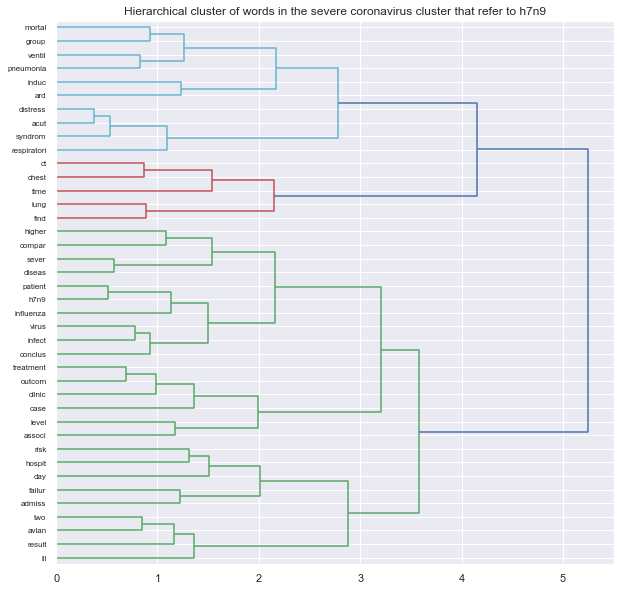

In [16]:
vectorizer = TfidfVectorizer(max_features=40) # use top 40 words to identify themes 

features = pd.DataFrame(vectorizer.fit_transform(homework['stemmed_abs']).toarray(),
                            columns=vectorizer.get_feature_names()).T
dist = 1-cosine_similarity(features)

linkage = ward(dist)

plt.figure(figsize=(10,10))
ax = dendrogram(linkage, labels=vectorizer.get_feature_names(), orientation='right')
plt.title('Hierarchical cluster of words in the severe coronavirus cluster that refer to h7n9')

The red cluster in the above diagram is extremely interesting. As a reminder the severe coronavirus case cluster (cluster 1) was analyzed using hierarchical clustering. Features in this word were clusered around recovery, and a highly associated word was found to be h7n9. Further analyzing the papers within the cluster 1 that specifically mention h7n9 produced the above graph. The red cluster above shows a significant correlation between the words 'ct', 'chest', 'lung', 'time', 'find'. This provides some evidence that early detection of h7n9 was vital to ensure recovery of patients and may suggest that by implementing rapid CT scanners as a method of detection across the country can increase the detection rate of coronavirus and decrease mortality of the disease. 

This is even more interesting when considering the techniques used by the South Korean and Chinese governments which used a massive mobilization of mobile CT scanner to do exactly the above. South Korea in particular has seen an aggressive 'flattening of the curve' through a combination of early detection and social distancing.

### Cluster 15 Analysis

A final analysis is conducted on cluster 15. Cluster 15 contains papers which reference risk factors for contracting an infectious respiratory illness. The abstracts are analyzed to identify charateristics that make certain groups more vulnerable to respiratory illness than others. 

In [32]:
vectorizer = TfidfVectorizer(max_features=800)

features = pd.DataFrame(vectorizer.fit_transform(clusters[15]['stemmed_abs']).toarray(),
                        columns=vectorizer.get_feature_names()).T

dist = 1-cosine_similarity(features)
featureWords = vectorizer.get_feature_names()

vulnInd = np.arange(len(dist[featureWords.index('morbid')]))
mortInd = np.arange(len(dist[featureWords.index('mortal')]))
riskInd = np.arange(len(dist[featureWords.index('risk')]))

def cluster_words(index, features, target):
    target_words = sorted(zip(dist[features.index(target)], index))
    out_words = []
    for word in target_words[0:60]:
        out_words.append(features[word[1]])

    return out_words


vulnWords = cluster_words(detInd, featureWords, 'morbid')
mortWords = cluster_words(prevInd, featureWords, 'mortal')
riskWords = cluster_words(spreadInd, featureWords, 'risk')

df = pd.DataFrame([vulnWords, mortWords, riskWords], 
                    index=['morbid', 'mortal', 'risk']).T

df.head(20)

,morbid,mortal,risk
0,morbid,mortal,risk
1,mortal,associ,factor
2,adjust,death,associ
3,caus,caus,95
4,pneumonia,morbid,ci
5,calv,rate,studi
6,elder,increas,increas
7,diseas,65,signific
8,associ,studi,conclus
9,respiratori,diseas,infect


From the above it can be very clearly seen that a significant risk factor which increases susceptibility to an infectious respiratory disease is age. Those in higher age groups are likely more susceptible to contract an infectious respiratory illness. 

## Conclusions and Policy Suggestions 

There are a multitude of ways that this data can be analyzed and used to draw conclusions. The investigation presented above used k-means clustering to group similar papers together. Clinicians and lawmakers can use these clusters to target their research efforts. Additionally, these subgroups were analyzed using hierarchical clustering and distance calculations to draw the below insights. 
1. early containment is vital to stopping disease spread
2. early lung CT scans of patients suffereing from CoVID-19 may increase likelihood of recovery 
3. individuals in advanced age are more susecptible to contracting infectious respiratory illnesses

To address early containment the below policy suggestions should be considered: 
* a policy of social distancing should be implemented
* contact between people should be reduced
* non essential business should be shuttered 
* high traffic areas like parks, beaches, and playgrounds should be closed 
* high volume events like concerts, parades, and festivals should be cancelled 

To adress early detection the below policy suggestions should be considered: 
* rapid testing methods like portable CT scanners should be deployed across the country
* drive through testing centres should be opened to both reduce contact between healthcare workers and increase testing throughput 
* <b> clear </b> instruction should be provided to the public on how, where, and when to get tested

To address high risk groups the below policy suggestions should be considered: 
* senior centres/old age homes should only allow admittance to people who have <b> tested </b> negative for CoVID-19
* all staff working with people in advanced age should be tested regularly
* people who test positive for CoVID-19 should not be allowed to come into contact with seniors 

It is the sincere hope of this author that some of this information will be useful in the fight against the novel coronavirus and that through the use of a concerted effort society will be able to contain this outbreak. 